# Phân tích tác động của thuốc điều trị đến biến chứng

## Mục tiêu:
- Phân tích hiệu quả của các loại thuốc (prop, nitr, pro, diuretic, xhypo) trong việc giảm biến chứng
- So sánh tỷ lệ biến chứng giữa nhóm dùng và không dùng từng loại thuốc
- Phân tích các tổ hợp thuốc và hiệu quả điều trị

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import itertools
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

df = pd.read_csv('../data/processed/processed_heart_disease.csv')

In [2]:
df['has_complication'] = (df['num'] > 0).astype(int)

# Định nghĩa các biến thuốc điều trị
medication_vars = ['prop', 'nitr', 'pro', 'diuretic', 'xhypo']
medication_labels = ['Thuốc chẹn beta', 'Thuốc nitrate', 'Thuốc khác', 'Thuốc lợi tiểu', 'Thuốc lipid']

# Kiểm tra các biến có trong dữ liệu
available_meds = [var for var in medication_vars if var in df.columns]
available_med_labels = [label for var, label in zip(medication_vars, medication_labels) if var in df.columns]

print("Thông tin về các loại thuốc trong dữ liệu:")
for var, label in zip(available_meds, available_med_labels):
    usage_count = df[var].sum()
    total_count = len(df)
    usage_rate = usage_count / total_count * 100
    print(f"{label} ({var}): {usage_count}/{total_count} bệnh nhân ({usage_rate:.1f}%)")

print(f"\nTổng số loại thuốc được phân tích: {len(available_meds)}")

Thông tin về các loại thuốc trong dữ liệu:
Thuốc chẹn beta (prop): 100/308 bệnh nhân (32.5%)
Thuốc nitrate (nitr): 77/308 bệnh nhân (25.0%)
Thuốc khác (pro): 34/308 bệnh nhân (11.0%)
Thuốc lợi tiểu (diuretic): 38/308 bệnh nhân (12.3%)
Thuốc lipid (xhypo): 6/308 bệnh nhân (1.9%)

Tổng số loại thuốc được phân tích: 5


### Tỷ lệ biến chứng theo từng loại thuốc

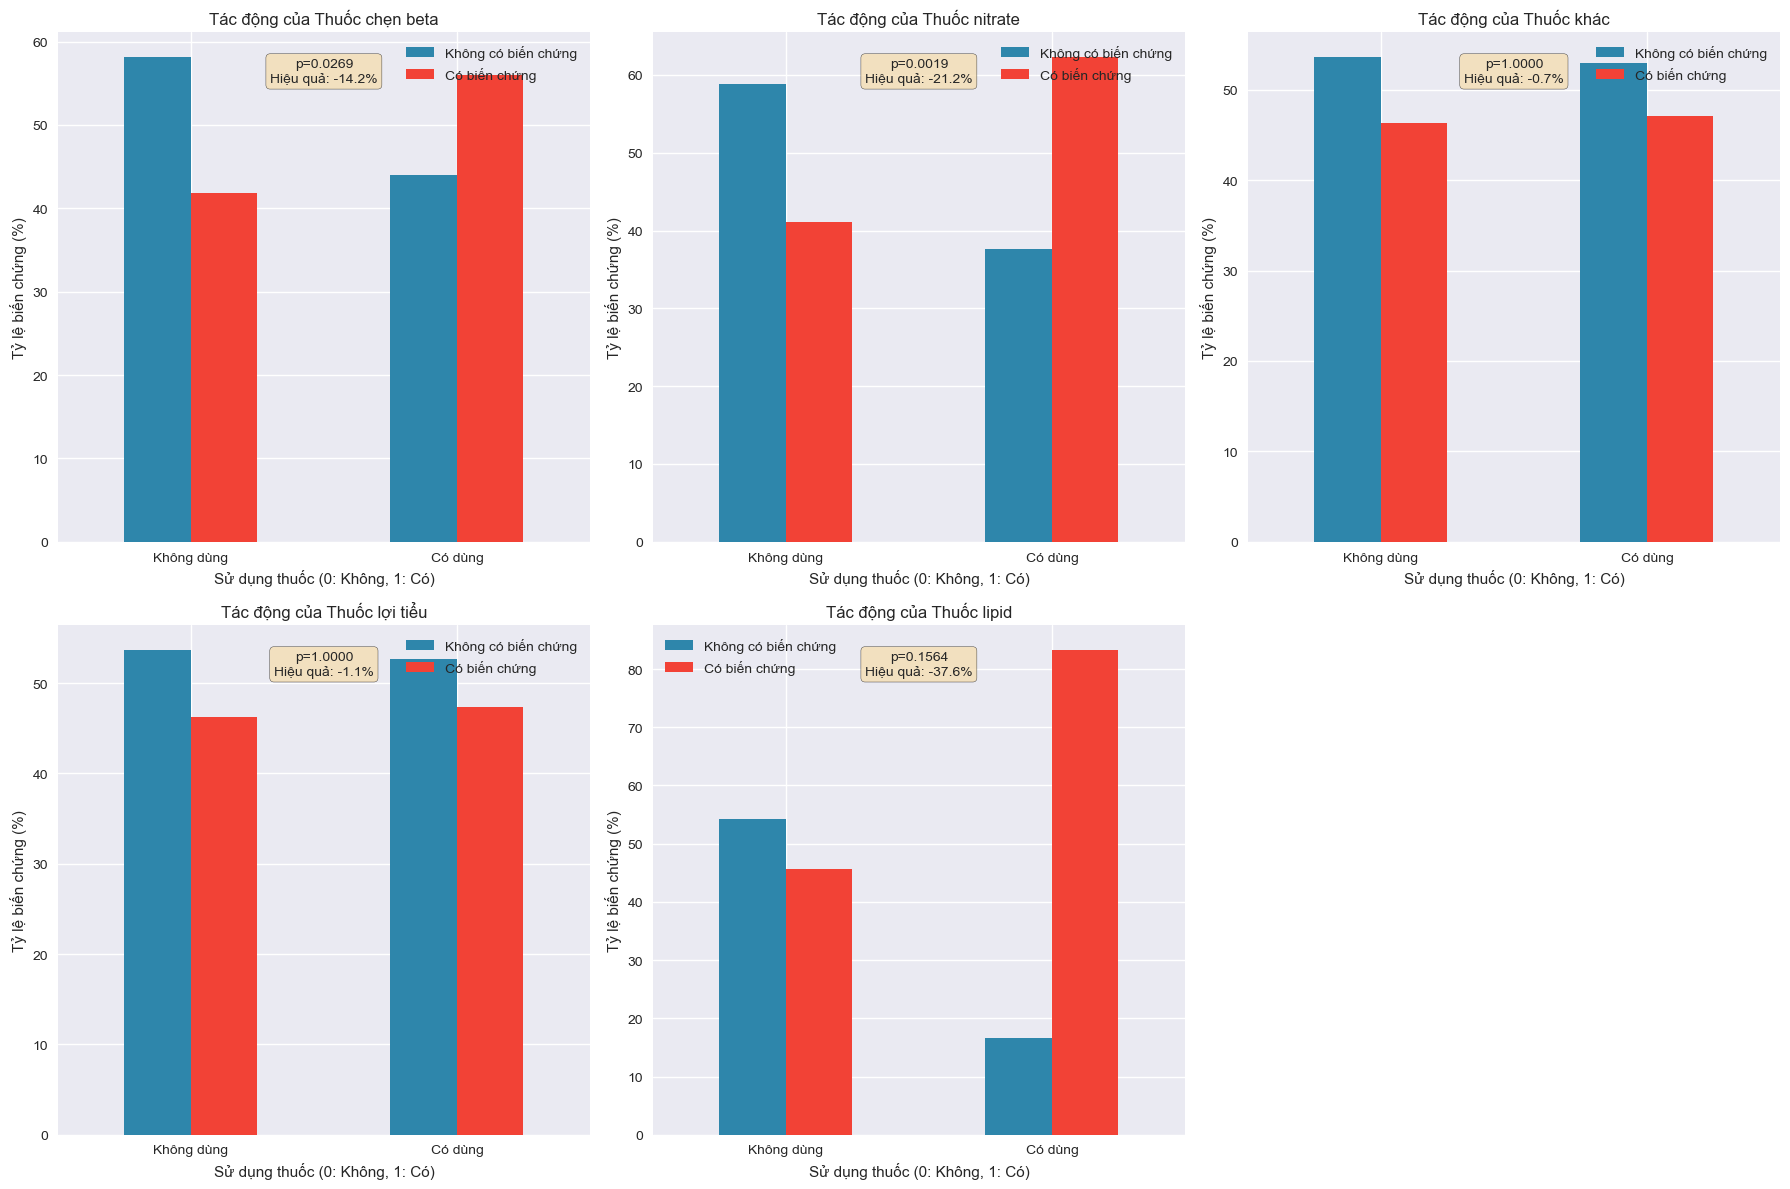


Bảng tóm tắt hiệu quả các loại thuốc:
             Thuốc  Không dùng (%)  Có dùng (%)  Hiệu quả (%)  p_value
2       Thuốc khác           46.35        47.06         -0.71     1.00
3   Thuốc lợi tiểu           46.30        47.37         -1.07     1.00
0  Thuốc chẹn beta           41.83        56.00        -14.17     0.03
1    Thuốc nitrate           41.13        62.34        -21.21     0.00
4      Thuốc lipid           45.70        83.33        -37.64     0.16


In [3]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

medication_effects = []

for i, (var, label) in enumerate(zip(available_meds, available_med_labels)):
    if i < len(axes):
        # Tính tỷ lệ biến chứng
        ct = pd.crosstab(df[var], df['has_complication'], normalize='index') * 100
        
        # Vẽ biểu đồ
        ct.plot(kind='bar', ax=axes[i], color=['#2E86AB', '#F24236'])
        axes[i].set_title(f'Tác động của {label}')
        axes[i].set_xlabel('Sử dụng thuốc (0: Không, 1: Có)')
        axes[i].set_ylabel('Tỷ lệ biến chứng (%)')
        axes[i].legend(['Không có biến chứng', 'Có biến chứng'])
        axes[i].set_xticklabels(['Không dùng', 'Có dùng'], rotation=0)
        
        # Tính chi-square test
        ct_counts = pd.crosstab(df[var], df['has_complication'])
        chi2, p_value, _, _ = stats.chi2_contingency(ct_counts)
        
        # Tính hiệu quả (% giảm biến chứng)
        no_med_rate = df[df[var] == 0]['has_complication'].mean() * 100
        with_med_rate = df[df[var] == 1]['has_complication'].mean() * 100
        effectiveness = no_med_rate - with_med_rate
        
        medication_effects.append({
            'Thuốc': label,
            'Không dùng (%)': no_med_rate,
            'Có dùng (%)': with_med_rate,
            'Hiệu quả (%)': effectiveness,
            'p_value': p_value
        })
        
        # Add p-value và hiệu quả
        axes[i].text(0.5, 0.95, f'p={p_value:.4f}\nHiệu quả: {effectiveness:+.1f}%', 
                    transform=axes[i].transAxes, ha='center', va='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

for j in range(len(available_meds), len(axes)):
    axes[j].remove()

plt.tight_layout()
plt.show()

# Show
effects_df = pd.DataFrame(medication_effects)
effects_df = effects_df.sort_values('Hiệu quả (%)', ascending=False)
print("\nBảng tóm tắt hiệu quả các loại thuốc:")
print(effects_df.round(2))

### Heatmap tương quan giữa các loại thuốc

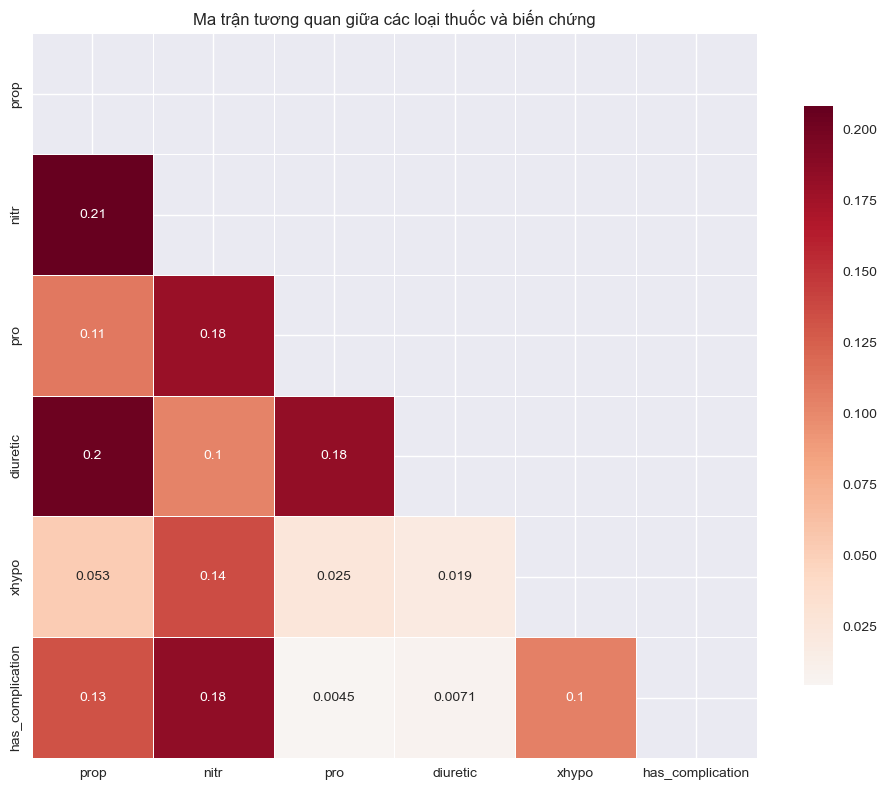

In [4]:
if len(available_meds) > 1:
    med_vars_with_target = available_meds + ['has_complication']
    corr_matrix = df[med_vars_with_target].corr()
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Ma trận tương quan giữa các loại thuốc và biến chứng')
    plt.tight_layout()
    plt.show()
else:
    print("Cần ít nhất 2 loại thuốc để tạo ma trận tương quan.")

### Phân tích số lượng thuốc sử dụng

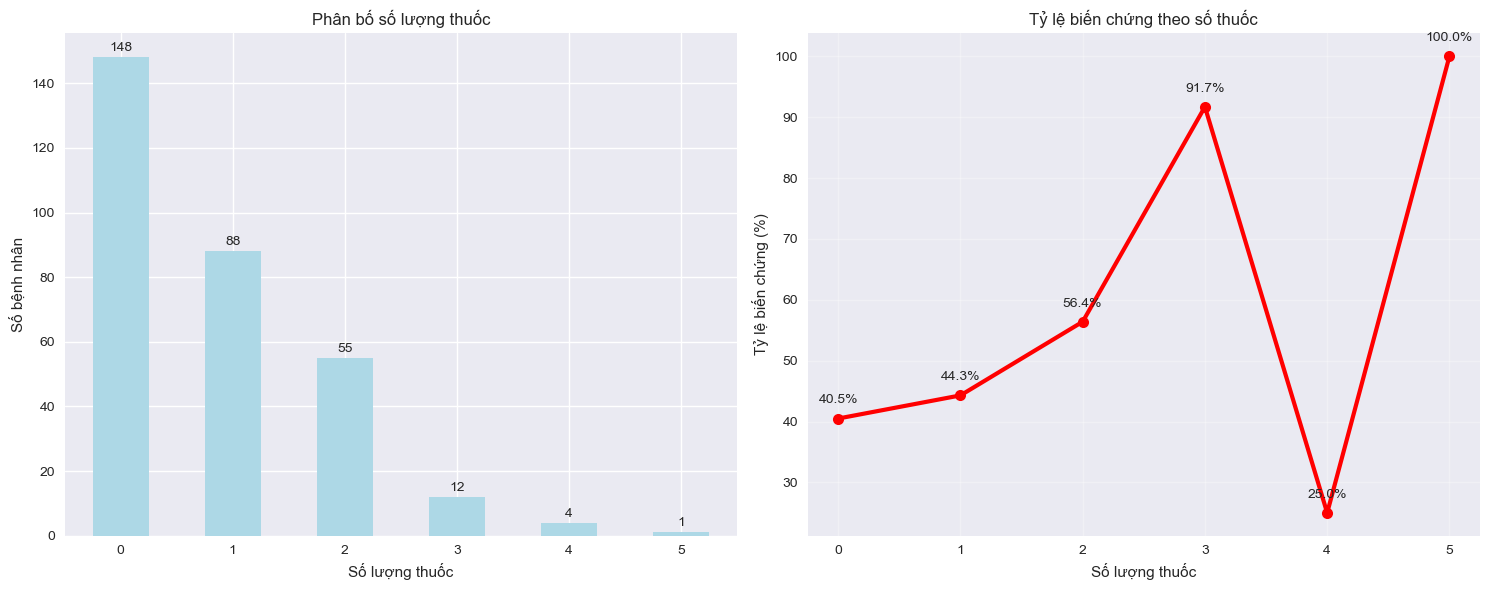


Thống kê theo số lượng thuốc:
                   Số bệnh nhân  Tỷ lệ biến chứng
total_medications                                
0                           148             0.405
1                            88             0.443
2                            55             0.564
3                            12             0.917
4                             4             0.250
5                             1             1.000


In [5]:
# Tính tổng số thuốc mỗi bệnh nhân sử dụng
df['total_medications'] = df[available_meds].sum(axis=1)

# Phân tích theo số lượng thuốc
med_count_analysis = df.groupby('total_medications').agg({
    'has_complication': ['count', 'mean']}).round(3)
med_count_analysis.columns = ['Số bệnh nhân', 'Tỷ lệ biến chứng']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot - Phân bố số lượng thuốc
med_count_analysis['Số bệnh nhân'].plot(kind='bar', ax=axes[0], color='lightblue')
axes[0].set_title('Phân bố số lượng thuốc')
axes[0].set_xlabel('Số lượng thuốc')
axes[0].set_ylabel('Số bệnh nhân')
axes[0].tick_params(axis='x', rotation=0)

# Thêm số lượng lên cột
for i, v in enumerate(med_count_analysis['Số bệnh nhân']):
    axes[0].text(i, v + 1, str(int(v)), ha='center', va='bottom')

# Line plot - Tỷ lệ biến chứng theo số thuốc
(med_count_analysis['Tỷ lệ biến chứng'] * 100).plot(
    kind='line', ax=axes[1], color='red', marker='o', linewidth=3, markersize=8
)
axes[1].set_title('Tỷ lệ biến chứng theo số thuốc')
axes[1].set_xlabel('Số lượng thuốc')
axes[1].set_ylabel('Tỷ lệ biến chứng (%)')
axes[1].grid(True, alpha=0.3)

# Thêm giá trị trên các điểm
for i, v in enumerate(med_count_analysis['Tỷ lệ biến chứng'] * 100):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nThống kê theo số lượng thuốc:")
print(med_count_analysis)

### Phân tích hiệu quả thuốc theo nhóm tuổi và giới tính

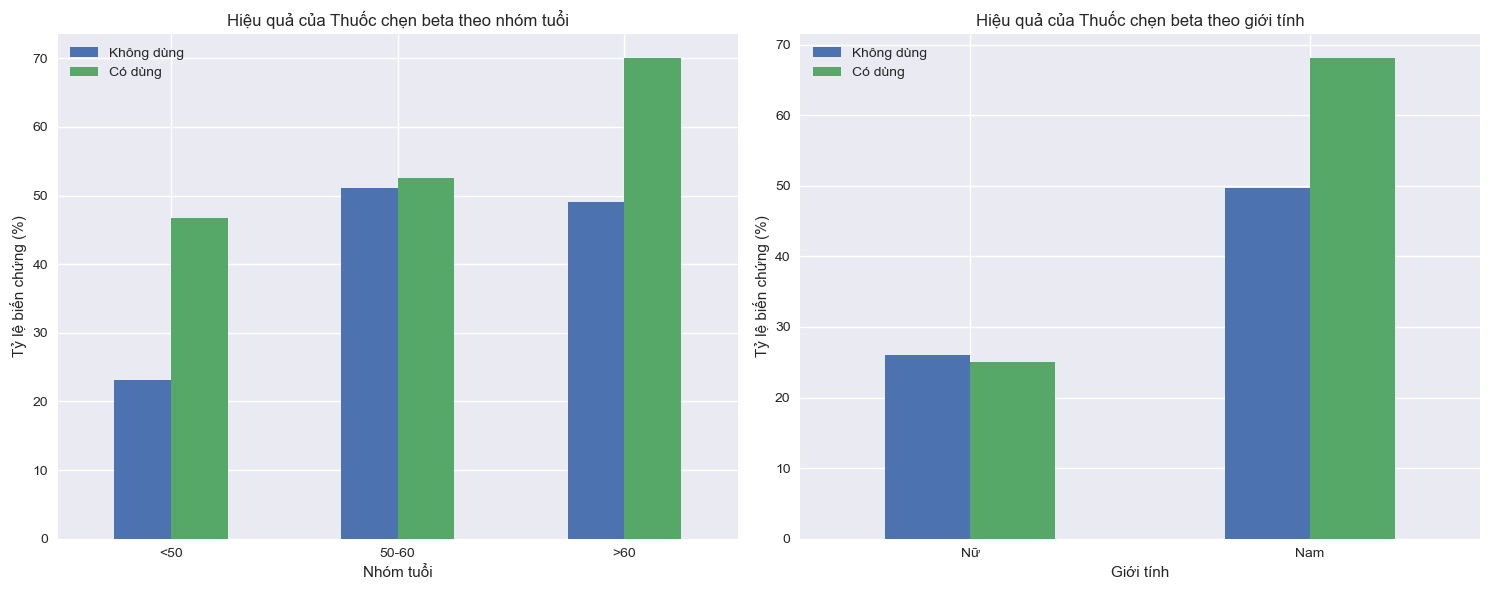

In [6]:
df['age_group'] = pd.cut(df['age'], 
                        bins=[0, 50, 60, 100], 
                        labels=['<50', '50-60', '>60'])

# Phân tích hiệu quả thuốc theo nhóm tuổi (chọn thuốc có hiệu quả nhất)
if 'effects_df' in locals() and not effects_df.empty:
    best_med_var = None
    best_med_label = None
    
    # Tìm thuốc có hiệu quả cao nhất và có ý nghĩa thống kê
    significant_meds = effects_df[effects_df['p_value'] < 0.05]
    if not significant_meds.empty:
        best_med_label = significant_meds.iloc[0]['Thuốc']
        # Tìm variable name tương ứng
        for var, label in zip(available_meds, available_med_labels):
            if label == best_med_label:
                best_med_var = var
                break
    
    if best_med_var:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Theo nhóm tuổi
        age_med_analysis = df.groupby(['age_group', best_med_var])['has_complication'].mean().unstack() * 100
        age_med_analysis.plot(kind='bar', ax=axes[0], rot=0)
        axes[0].set_title(f'Hiệu quả của {best_med_label} theo nhóm tuổi')
        axes[0].set_xlabel('Nhóm tuổi')
        axes[0].set_ylabel('Tỷ lệ biến chứng (%)')
        axes[0].legend(['Không dùng', 'Có dùng'])
        
        # Theo giới tính
        sex_med_analysis = df.groupby(['sex', best_med_var])['has_complication'].mean().unstack() * 100
        sex_med_analysis.index = ['Nữ', 'Nam']
        sex_med_analysis.plot(kind='bar', ax=axes[1], rot=0)
        axes[1].set_title(f'Hiệu quả của {best_med_label} theo giới tính')
        axes[1].set_xlabel('Giới tính')
        axes[1].set_ylabel('Tỷ lệ biến chứng (%)')
        axes[1].legend(['Không dùng', 'Có dùng'])
        
        plt.tight_layout()
        plt.show()
    else:
        print("Không tìm thấy thuốc có hiệu quả đáng kể để phân tích chi tiết.")
else:
    print("Chưa có dữ liệu về hiệu quả thuốc để phân tích chi tiết.")


### Phân tích tổ hợp thuốc hiệu quả

In [7]:
# Phân tích tổ hợp thuốc hiệu quả
if len(available_meds) >= 2:
    print("Phân tích tổ hợp thuốc hiệu quả...")
    
    # Tạo tất cả các tổ hợp có thể từ 2-4 thuốc
    combo_results = []
    
    for r in range(2, min(5, len(available_meds) + 1)):
        for combo in itertools.combinations(available_meds, r):
            # Tạo mask cho tổ hợp này
            combo_mask = (df[list(combo)].sum(axis=1) == len(combo)) & \
                        (df[available_meds].drop(columns=list(combo)).sum(axis=1) == 0)
            
            if combo_mask.sum() >= 10:  # Ít nhất 10 bệnh nhân
                complication_rate = df[combo_mask]['has_complication'].mean()
                patient_count = combo_mask.sum()
                
                combo_results.append({
                    'Tổ hợp': ' + '.join([available_med_labels[available_meds.index(med)] for med in combo]),
                    'Số bệnh nhân': patient_count,
                    'Tỷ lệ biến chứng': complication_rate,
                    'Thuốc': combo
                })
    
    if combo_results:
        combo_df = pd.DataFrame(combo_results)
        combo_df = combo_df.sort_values('Tỷ lệ biến chứng')
        
        # Lọc các tổ hợp có ít nhất 15 bệnh nhân
        combo_filtered = combo_df[combo_df['Số bệnh nhân'] >= 15]
        
        if not combo_filtered.empty:
            print("\nTop 10 tổ hợp thuốc hiệu quả nhất (≥15 bệnh nhân):")
            print(combo_filtered.head(10)[['Tổ hợp', 'Số bệnh nhân', 'Tỷ lệ biến chứng']].round(3))
            
            # Vẽ biểu đồ top 5 tổ hợp
            if len(combo_filtered) >= 5:
                top_combos = combo_filtered.head(5)
                
                plt.figure(figsize=(12, 8))
                bars = plt.bar(range(len(top_combos)), top_combos['Tỷ lệ biến chứng'] * 100)
                plt.xticks(range(len(top_combos)), 
                          [combo[:30] + '...' if len(combo) > 30 else combo 
                           for combo in top_combos['Tổ hợp']], 
                          rotation=45, ha='right')
                plt.ylabel('Tỷ lệ biến chứng (%)')
                plt.title('Top 5 tổ hợp thuốc hiệu quả nhất')
                
                # Thêm số lượng bệnh nhân lên cột
                for i, (bar, count) in enumerate(zip(bars, top_combos['Số bệnh nhân'])):
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                            f'n={int(count)}', ha='center', va='bottom')
                
                plt.tight_layout()
                plt.show()
        else:
            combo_filtered = pd.DataFrame()  # Tạo DataFrame rỗng
            print("Không có tổ hợp thuốc nào có đủ dữ liệu để phân tích (≥15 bệnh nhân)")
    else:
        combo_filtered = pd.DataFrame()  # Tạo DataFrame rỗng
        print("Không có tổ hợp thuốc nào có đủ dữ liệu để phân tích")
else:
    combo_filtered = pd.DataFrame()  # Tạo DataFrame rỗng
    print("Cần ít nhất 2 loại thuốc để phân tích tổ hợp")

Phân tích tổ hợp thuốc hiệu quả...

Top 10 tổ hợp thuốc hiệu quả nhất (≥15 bệnh nhân):
                            Tổ hợp  Số bệnh nhân  Tỷ lệ biến chứng
0  Thuốc chẹn beta + Thuốc nitrate            24              0.75


### KẾT LUẬN VÀ ĐỀ XUẤT PHÁC ĐỒ ĐIỀU TRỊ

In [11]:
if available_meds and 'effects_df' in locals():
    print("HIỆU QUẢ CỦA TỪNG LOẠI THUỐC:")
    
    for _, row in effects_df.iterrows():
        significance = "có ý nghĩa" if row['p_value'] < 0.05 else "không có ý nghĩa"
        effectiveness_desc = "có hiệu quả" if row['Hiệu quả (%)'] > 0 else "không hiệu quả hoặc có hại"
        
        print(f"\n   • {row['Thuốc']}:")
        print(f"     - Giảm biến chứng: {row['Hiệu quả (%)']:.1f}%")
        print(f"     - Ý nghĩa thống kê: {significance} (p={row['p_value']:.4f})")
        print(f"     - Đánh giá: {effectiveness_desc}")
    
    # Thuốc hiệu quả nhất
    most_effective = effects_df[effects_df['p_value'] < 0.05]
    if not most_effective.empty:
        best_drug = most_effective.iloc[0]
        print(f"\n2. THUỐC HIỆU QUẢ NHẤT:")
        print(f"   {best_drug['Thuốc']} - Giảm biến chứng {best_drug['Hiệu quả (%)']:.1f}%")
    
    # Phân tích theo số lượng thuốc
    if 'total_medications' in df.columns:
        print("\n3. PHÂN TÍCH THEO SỐ LƯỢNG THUỐC:")
        med_count_stats = df.groupby('total_medications')['has_complication'].mean() * 100
        for count, rate in med_count_stats.items():
            patient_count = (df['total_medications'] == count).sum()
            print(f"   - {count} thuốc: {rate:.1f}% biến chứng (n={patient_count})")
    
    # Tổ hợp thuốc hiệu quả
    if 'combo_filtered' in locals() and not combo_filtered.empty:
        print("\n4. TỔ HỢP THUỐC HIỆU QUẢ NHẤT:")
        best_combo = combo_filtered.iloc[0]
        print(f"   {best_combo.name}: {best_combo['Tỷ lệ biến chứng']*100:.1f}% biến chứng")
    
    print("\n5. ĐỀ XUẤT PHÁC ĐỒ ĐIỀU TRỊ:")
    print("   a) Ưu tiên sử dụng:")
    
    # Sắp xếp thuốc theo hiệu quả
    effective_drugs = effects_df[(effects_df['p_value'] < 0.05) & (effects_df['Hiệu quả (%)'] > 0)]
    if not effective_drugs.empty:
        for i, (_, row) in enumerate(effective_drugs.iterrows(), 1):
            print(f"      {i}. {row['Thuốc']} (giảm {row['Hiệu quả (%)']:.1f}% biến chứng)")
    else:
        print("      Không có thuốc nào cho thấy hiệu quả rõ rệt")
    
    print("Cân nhắc tránh:")
    harmful_drugs = effects_df[effects_df['Hiệu quả (%)'] < -2]  # Tăng biến chứng > 2%
    if not harmful_drugs.empty:
        for _, row in harmful_drugs.iterrows():
            print(f"      - {row['Thuốc']} (tăng {abs(row['Hiệu quả (%)']):.1f}% biến chứng)")
    else:
        print("      Không có thuốc nào cho thấy tác hại rõ rệt")

else:
    print("Không đủ dữ liệu để đưa ra kết luận về hiệu quả điều trị.")

HIỆU QUẢ CỦA TỪNG LOẠI THUỐC:

   • Thuốc khác:
     - Giảm biến chứng: -0.7%
     - Ý nghĩa thống kê: không có ý nghĩa (p=1.0000)
     - Đánh giá: không hiệu quả hoặc có hại

   • Thuốc lợi tiểu:
     - Giảm biến chứng: -1.1%
     - Ý nghĩa thống kê: không có ý nghĩa (p=1.0000)
     - Đánh giá: không hiệu quả hoặc có hại

   • Thuốc chẹn beta:
     - Giảm biến chứng: -14.2%
     - Ý nghĩa thống kê: có ý nghĩa (p=0.0269)
     - Đánh giá: không hiệu quả hoặc có hại

   • Thuốc nitrate:
     - Giảm biến chứng: -21.2%
     - Ý nghĩa thống kê: có ý nghĩa (p=0.0019)
     - Đánh giá: không hiệu quả hoặc có hại

   • Thuốc lipid:
     - Giảm biến chứng: -37.6%
     - Ý nghĩa thống kê: không có ý nghĩa (p=0.1564)
     - Đánh giá: không hiệu quả hoặc có hại

2. THUỐC HIỆU QUẢ NHẤT:
   Thuốc chẹn beta - Giảm biến chứng -14.2%

3. PHÂN TÍCH THEO SỐ LƯỢNG THUỐC:
   - 0 thuốc: 40.5% biến chứng (n=148)
   - 1 thuốc: 44.3% biến chứng (n=88)
   - 2 thuốc: 56.4% biến chứng (n=55)
   - 3 thuốc: 91.7% bi